In [393]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and clean the Data

In [3]:
# load the data
row_data = pd.read_excel("data/20240725_systematic_litterature_review.xlsx")
row_data.columns = row_data.iloc[0]
row_data = row_data[1:]
#row_data.to_csv("data/20240725_systematic_litterature_review.csv", index=False)

In [77]:
from preprocessing import clean_sample_size, clean_percentage_male, clean_age, compute_prevalence_PTSD, categorize_event_2, clean_n_PTSD, is_specified
from preprocessing import normalize_recruitment_method, normalize_exclusion_criteria, normalize_inclusion_criteria
from preprocessing import categorize_recruitment_method, is_specified_criteria


def clean_data(row_data):  
    row_data['discipline_clean'] =  row_data.apply(
        lambda x: ', '.join([disc for disc, is_involved in zip(
            ['Computer Science', 'Clinical Science', 'Linguistic'], 
            [x['Computer_science_cat'], x['Clinical_science_cat'], x['Lingusitic_cat']]
        ) if is_involved]), axis=1)

    row_data['statistical_framework_clean'] = row_data.apply(
        lambda x: ', '.join([framework for framework, is_used in zip(
            ['Descriptive statistics', 'Inferential statistics', 'Supervised Machine Learning', 'Supervised Deep Learning'], 
            [x['cat_framework_Descriptive statistics, (p-value f-value effect size)'], 
            x['Cat_framework_Inferential statistics (regression analysis)'], 
            x['cat_framework_Supervised Machine  Learning'], 
            x['cat_framework_Supervised Deep Learning']]
        ) if is_used]), axis=1)

    row_data['type of diagnosis tool used'] = row_data['type of diagnosis tool used'].apply(lambda x : "clinical-administered" if x =="Clinical interview" else x)
    row_data['type of diagnosis tool used'] = row_data['type of diagnosis tool used'].apply(lambda x : "self-administrated" if x =="DSM-standards" else x)
    row_data['Method to extract language features'] = row_data['Method to extract language features'].apply(lambda x : "External Dictionary Word Count" if x =="External Dictionary Word Coun" else x)
    row_data['Method to extract language features'] = row_data['Method to extract language features'].apply(lambda x : "Embedding;N-gram;TF-IDF..." if x =="Statistical and Machine Learning Methods such as Embeddings" else x)


    row_data['cleaned_sample_size'] = row_data['sample_size'].apply(clean_sample_size)   
    row_data['cleaned_%_male'] = row_data['%_male'].apply(clean_percentage_male)
    row_data['cleaned_age_mean_SD'] = row_data['age (mean /SD)'].apply(clean_age)
    row_data['cleaned_n_PTSD'] = row_data['n_PTSD'].apply(clean_n_PTSD)

    row_data['prevalence_PTSD'] = row_data.apply(compute_prevalence_PTSD, axis=1)

    row_data['event_type_clean'] = row_data['event_type'].apply(categorize_event_2)


    row_data['recruitment_date_specified'] = row_data['recrutment_date'].apply(is_specified)
    

    # Normalize exclusion  and inclusion criteria
    row_data['normalized_recruitment_methods'] = row_data['recrutement_methods'].apply(normalize_recruitment_method)
    row_data['normalized_exclusion_criteria'] = row_data['exclusion_criteria'].apply(normalize_exclusion_criteria)
    row_data['normalized_inclusion_criteria'] = row_data['inclusion criteria'].apply(normalize_inclusion_criteria)

    # 
    row_data['recruitment_category'] = row_data['recrutement_methods'].apply(categorize_recruitment_method)


    # 
    row_data['inclusion_criteria_specified'] = row_data['inclusion criteria'].apply(is_specified_criteria)
    row_data['exclusion_criteria_specified'] = row_data['exclusion_criteria'].apply(is_specified_criteria)
    row_data['recrutement_methods_specified'] = row_data['recrutement_methods'].apply(is_specified_criteria)
    row_data['recruitment_date_specified'] = row_data['recrutment_date'].apply(is_specified_criteria)

    return row_data


## Figure 2. Number of Studies Over Time (Grouped by 2-Year Intervals)				


/tmp/ipykernel_2252709/2890746938.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2252709/2890746938.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



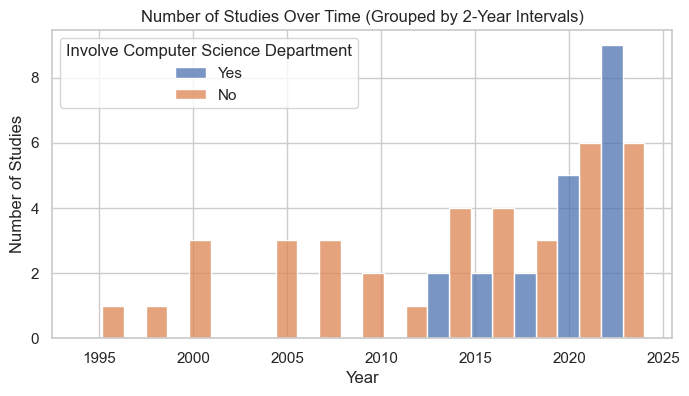

In [75]:
df  = row_data
df['date_year'] = df['date_year'].fillna(0).astype(int)
df = df[df['date_year'] > 0]
df['year_interval'] = (df['date_year'] // 2) * 2
sns.set_theme(style="whitegrid",)
custom_blue = '#1f77b4'


df['Involve Computer Science Department'] = df["Computer_science_cat"].apply(lambda x : "Yes" if x == 1 else "No")
# Plot the number of studies over time
studies_per_year = df['date_year'].value_counts().sort_index()
cumulative_studies = studies_per_year.cumsum()

# Plot the number of studies over time using seaborn
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='year_interval', bins=len(df['year_interval'].unique()), color=custom_blue, hue = 'Involve Computer Science Department',multiple="dodge")
plt.title('Number of Studies Over Time (Grouped by 2-Year Intervals)')
plt.xlabel('Year')
plt.ylabel('Number of Studies')
plt.grid(True)
plt.show()

## Figure 3. Sankey Diagram.

In [78]:
# Extract relevant columns for the Sankey diagram
col_to_include = ['discipline_clean',
                   'study_objectives_cat',
                     'data_source_cat', 
                     'type of diagnosis tool used',
                     "Method to extract language features",
                     #"statistical_framework_clean"
                     ]


renaming_dict = {
    'discipline_clean': 'Discipline',
    'study_objectives_cat': 'Study Objectives',
    'data_source_cat': 'Data Source',
    'type of diagnosis tool used': 'Diagnosis Tool',
    'Method to extract language features': 'Language Features',
    'statistical_framework_clean': 'Statistical Framework'
}

sankey_data = row_data[col_to_include].dropna()
sankey_data = sankey_data.rename(columns=renaming_dict)



def get_sankey_counts(sankey_data):
    # Aggregating data to get counts for each path
    sankey_counts = sankey_data.groupby(list(sankey_data.columns)).size().reset_index(name='Count')
    return sankey_counts

def prepare_sankey_labels(sankey_counts):
    # Preparing data for the Sankey diagram
    labels = list(set(sankey_counts.values.flatten()))
    labels_dict = {label: idx for idx, label in enumerate(labels)}
    return labels, labels_dict

def create_sankey_sources_targets(sankey_counts, labels_dict):
    # Create source and target lists
    sources, targets, counts = [], [], []
    for i in range(len(sankey_counts.columns) - 2):
        sources += sankey_counts[sankey_counts.columns[i]].map(labels_dict).tolist()
        targets += sankey_counts[sankey_counts.columns[i + 1]].map(labels_dict).tolist()
        counts += sankey_counts['Count'].tolist()
    return sources, targets, counts

def create_sankey_figure(sources, targets, counts, labels, feature_names):
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=custom_blue
    ),
    link=dict(
        source=sources,
        target=targets,
        value=counts,
        color="lightblue"
    ))])

    annotations = []
    for i, feature in enumerate(feature_names):
        annotations.append(dict(
            x=0.1  +0.22 *i, y=1.05,
            xref='paper', yref='paper',
            text=feature,
            showarrow=False,
            font=dict(size=20)
        ))

    fig.update_layout(
        title_text="Sankey Diagram of Studies",
        font_size=18,
        annotations=annotations,
        width = 1300,
        height = 800
    )
    
    fig.show()
# Create Sankey diagram


sankey_counts = get_sankey_counts(sankey_data)
labels, labels_dict = prepare_sankey_labels(sankey_counts)
sources, targets, counts = create_sankey_sources_targets(sankey_counts, labels_dict)
create_sankey_figure(sources, targets, counts, labels, feature_names = list(sankey_data.columns))


## Figure 4.  Distribution of Sample Size Depending on the Type  Diagnosis Tool Used		


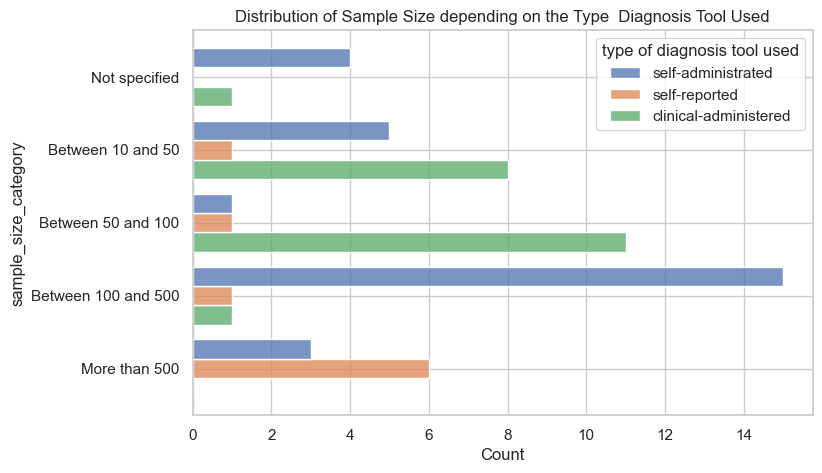

In [8]:
## Popualtion of the studies

# idea :  the more of the sample size rize the more the diaqnosis tool is weak.

def categorize_sample_size(sample_size):
    if sample_size == 'Not specified':
        return 'Not specified'
    if 10<sample_size < 50:
        return 'Between 10 and 50'
    if 50<sample_size < 100:
        return 'Between 50 and 100'
    if 100<sample_size < 500:
        return 'Between 100 and 500'
    if sample_size > 500:
        return 'More than 500'
    else:
        return 'Not specified'

category_order = ['Not specified', 'Between 10 and 50', 'Between 50 and 100', 'Between 100 and 500', 'More than 500']

row_data['sample_size_category'] = row_data['cleaned_sample_size'].apply(categorize_sample_size)
row_data['sample_size_category'] = pd.Categorical(row_data['sample_size_category'], categories=category_order, ordered=True)
# Plot the distribution of the sample size
plt.figure(figsize=(8, 5))
sns.histplot(data=row_data, y='sample_size_category', color=custom_blue, hue = "type of diagnosis tool used",  multiple='dodge', shrink=0.8,)
plt.title('Distribution of Sample Size depending on the Type  Diagnosis Tool Used')
plt.show()

## Figure S1.  Distribution of prevalence of PTSD depending on the Type  Diagnosis Tool Used'

/tmp/ipykernel_2252709/1219266029.py:3: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.




<Figure size 800x500 with 0 Axes>

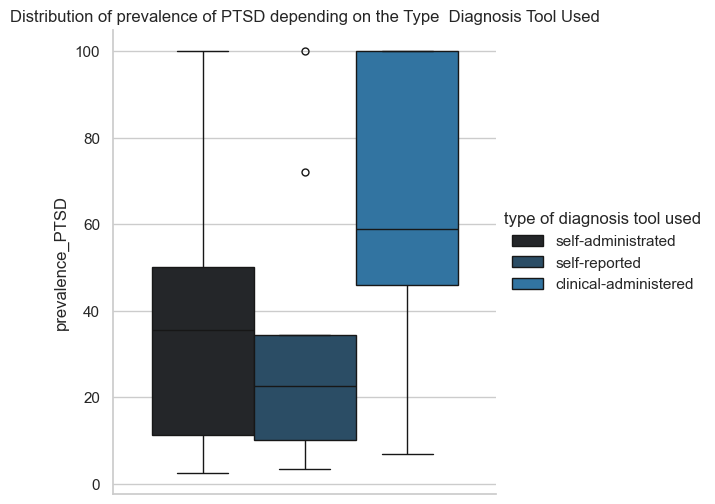

count     49.000000
mean      47.310643
std       32.353247
min        2.500000
25%       21.484716
50%       46.666667
75%       62.162162
max      100.000000
Name: prevalence_PTSD_cleaned, dtype: float64


In [28]:
row_data['prevalence_PTSD_cleaned'] = pd.to_numeric(df['prevalence_PTSD'], errors='coerce')
plt.figure(figsize=(8, 5))
sns.catplot(data=row_data[row_data.prevalence_PTSD_cleaned.notna()], y='prevalence_PTSD', color=custom_blue, hue = "type of diagnosis tool used", kind='box')
plt.title('Distribution of prevalence of PTSD depending on the Type  Diagnosis Tool Used')
plt.show()


print(row_data["prevalence_PTSD_cleaned"].describe())

## Figure 5. Distribution of the Percentage of Males in the Studies

<Figure size 800x300 with 0 Axes>

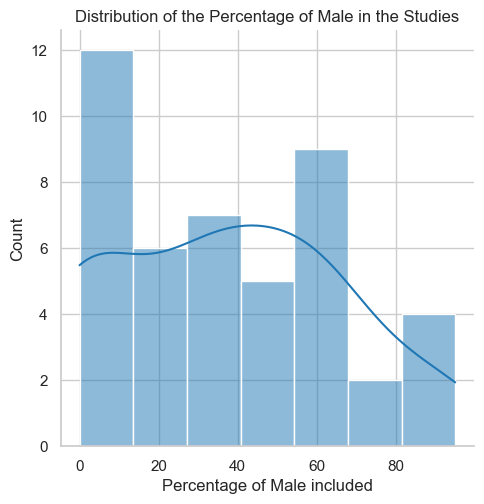

There is 45, (77.59)% studies where the percentage of male is specified.


In [29]:
n = row_data[row_data['cleaned_%_male'] != 'Not specified']
row_data['Percentage of Male included'] = row_data["cleaned_%_male"]


plt.figure(figsize=(8, 3))
sns.displot(data=n, x="Percentage of Male included", color=custom_blue, kde=True)
plt.title('Distribution of the Percentage of Male in the Studies')
plt.show()

print(f"There is {len(n)}, ({round(len(n)/len(row_data)*100,2)})% studies where the percentage of male is specified.")


## Information concerning Participants in the Studies (Age, recruitment category etc.)

In [11]:
n = row_data[row_data['cleaned_age_mean_SD'] != 'Not specified']

def clean_age(age):
    match = re.search(r'(\d+\.?\d*)\s*\(SD\s*([\d.]+|Not specified)\)', age)
    if match:
        mean_age = float(match.group(1))
        sd = match.group(2)
        sd = float(sd) if sd != 'Not specified' else None
        return mean_age, sd
    else:
        return None, None

# Apply the cleaning function and create new columns for mean age and SD
n['mean_age'], n['sd'] = zip(*n['age (mean /SD)'].apply(clean_age))

# Compute the mean of the means and the mean of the SDs, ignoring NaNs
mean_of_means = n['mean_age'].mean()
mean_of_sds = n['sd'].mean()

print(f"There is {len(n)}, ({round(len(n)/len(row_data)*100,2)})% studies where the age has been retrieved.")
print(f'Mean of means: {mean_of_means:.2f}')
print(f'Mean of standard deviations: {mean_of_sds:.2f}')


There is 40, (68.97)% studies where the age has been retrieved.
Mean of means: 47.93
Mean of standard deviations: 9.54


/tmp/ipykernel_2252709/368546797.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2252709/368546797.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
row_data['recruitment_category'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

recruitment_category
Direct Recruitment from Healthcare and Emergency Facilities    20.69%
Online Platforms and Social Media                              18.97%
Miscellaneous and Not Specified                                17.24%
Clinical Interviews and Direct Contact                         10.34%
Community and Association-Based Recruitment                     8.62%
Flyers, Advertisements, and Media                               6.90%
Automated Data Collection                                       6.90%
Referral and Professional Networks                              5.17%
Academic and Research Institutions                              5.17%
Name: proportion, dtype: object

In [30]:
print(f"Inclusion criteria are specified in {round(int(row_data['inclusion_criteria_specified'].value_counts()['Specified'])/len(row_data)*100,2)} % of the studies.")
print(f"Exclusion criteria are specified in {round(int(row_data['exclusion_criteria_specified'].value_counts()['Specified'])/len(row_data)*100,2)} % of the studies.")
print(f"Recruitment methods are specified in {round(int(row_data['recrutement_methods_specified'].value_counts()['Specified'])/len(row_data)*100,2)} % of the studies.")
print(f"Recruitment date is specified in {round(int(row_data['recruitment_date_specified'].value_counts()['Specified'])/len(row_data)*100,2)} % of the studies.")

Inclusion criteria are specified in 87.93 % of the studies.
Exclusion criteria are specified in 31.03 % of the studies.
Recruitment methods are specified in 75.86 % of the studies.
Recruitment date is specified in 44.83 % of the studies.


In [37]:
## Out come
# PTSD dianosis tool

row_data['type of diagnosis tool used'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

type of diagnosis tool used
self-administrated       48.28%
clinical-administered    36.21%
self-reported            15.52%
Name: proportion, dtype: object

In [44]:
cat = row_data[~row_data['prevalence_PTSD_cleaned'].isna()]

cat['prevalence_PTSD_cleaned'].describe()

count     49.000000
mean      47.310643
std       32.353247
min        2.500000
25%       21.484716
50%       46.666667
75%       62.162162
max      100.000000
Name: prevalence_PTSD_cleaned, dtype: float64

## Figure 6. Distribution of prevalence of PTSD depending on the Type of Diagnosis Tool Used		

/tmp/ipykernel_2252709/3293957217.py:2: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.




<Figure size 800x500 with 0 Axes>

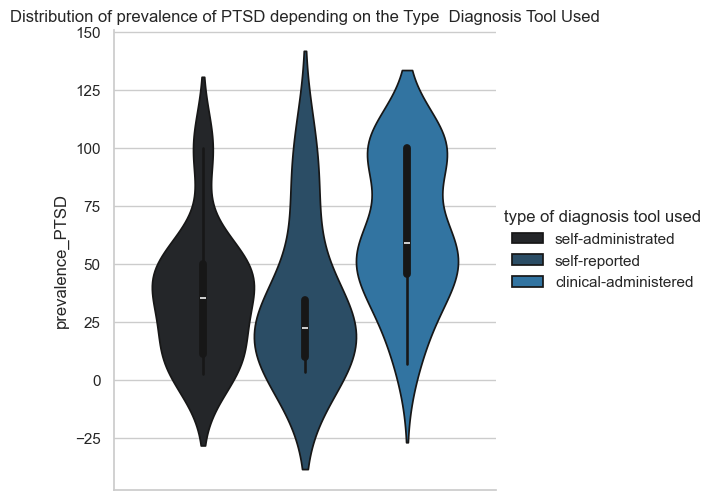

In [64]:
plt.figure(figsize=(8, 5))
sns.catplot(data=cat, y='prevalence_PTSD', color=custom_blue, hue = "type of diagnosis tool used", kind='violin')
plt.title('Distribution of prevalence of PTSD depending on the Type  Diagnosis Tool Used')
plt.show()


## Figure 7. Distribution of prevalence of PTSD depending on the type of Exposition		

/tmp/ipykernel_2252709/2311408923.py:2: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.




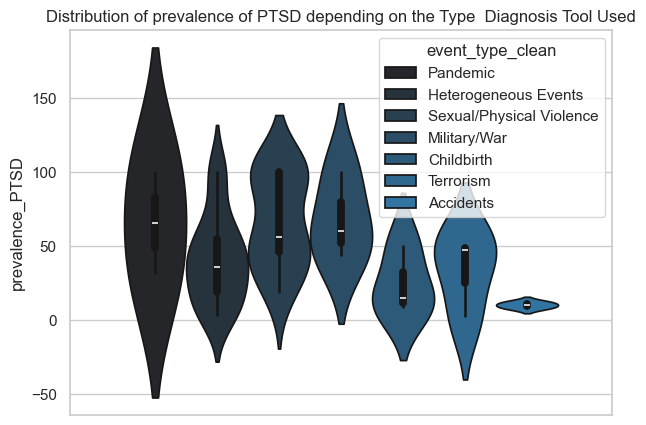

In [65]:
plt.figure(figsize=(7, 5))
sns.violinplot(data=cat, y='prevalence_PTSD', hue = "event_type_clean", color=custom_blue, )
plt.title('Distribution of prevalence of PTSD depending on the Type  Diagnosis Tool Used')
plt.show()


In [66]:
## Language features

row_data['Method to extract language features'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

Method to extract language features
External Dictionary Word Count    48.28%
Manual Annotation                 20.69%
Hybrid Approaches                 10.34%
Embedding;N-gram;TF-IDF...         8.62%
Transfer Learning Approach         6.90%
readability Scores                 5.17%
Name: proportion, dtype: object

## Figure 8. The kind of method used  to extract language features versus the Discipline involved	

Text(0.5, 1.0, 'Method to extract language features depending on the Discipline')

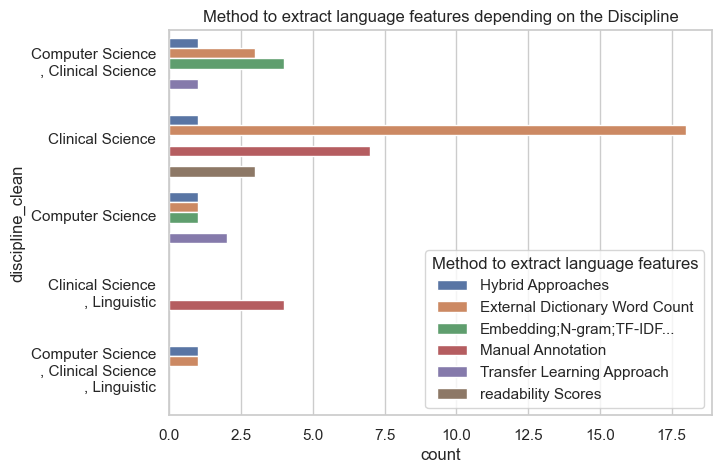

In [79]:
plt.figure(figsize=(7, 5))
sns.countplot(data=cat, y='discipline_clean', hue = "Method to extract language features", )
plt.title('Method to extract language features depending on the Discipline')

## Figure S2. Frequency of Statistical Frameworks Used

/tmp/ipykernel_2252709/406104299.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




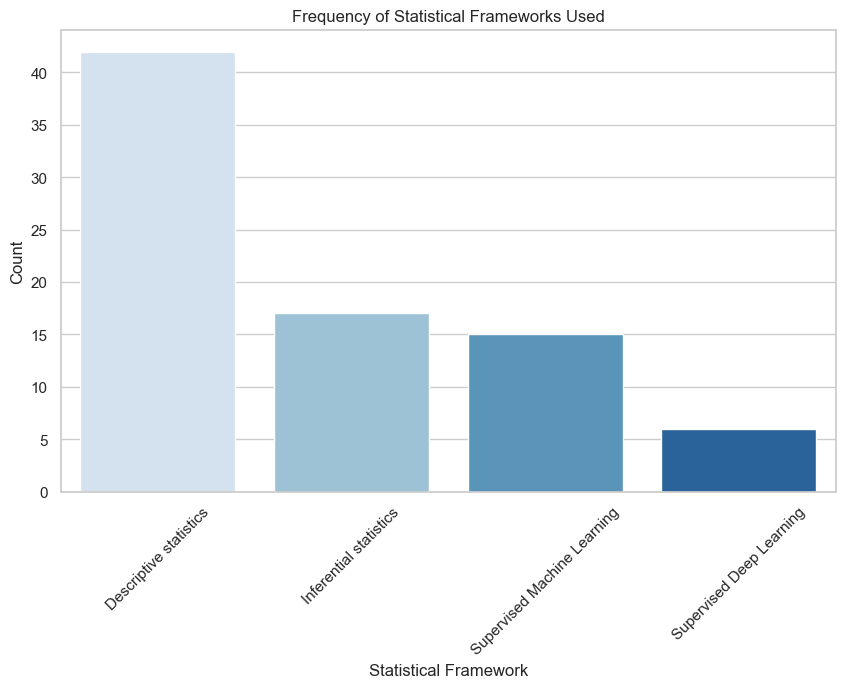

In [197]:


row_data['statistical_framework_list'] = row_data['statistical_framework_clean'].apply(lambda x: x.split(', ') if x != [] else x)
row_data['statistical_framework_list'] = row_data['statistical_framework_list'].apply(lambda x: [elt for elt in x if len(elt) >0 ])

# Create a DataFrame where each row represents a single framework used in a study
frameworks = row_data.explode('statistical_framework_list')

# Count the occurrences of each framework
framework_counts = frameworks['statistical_framework_list'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=framework_counts.index, y=framework_counts.values, palette="Blues")
plt.xlabel('Statistical Framework')
plt.ylabel('Count')
plt.title('Frequency of Statistical Frameworks Used')
plt.xticks(rotation=45)
plt.show()

In [198]:
frameworks['statistical_framework_list'].value_counts(normalize=True)

statistical_framework_list
Descriptive statistics         0.5250
Inferential statistics         0.2125
Supervised Machine Learning    0.1875
Supervised Deep Learning       0.0750
Name: proportion, dtype: float64

## Figure 9. The most common Comorbidity and co-founding factors employed in the studies

In [ ]:
def flatten_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

comorbidity = flatten_list(row_data["comorbity_included"].to_list())
confounding_factors = flatten_list(row_data["confounding_factors"].to_list())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plotting comorbidities
sns.countplot(ax=axes[0], y=comorbidity, color=custom_blue)
axes[0].set_title('Comorbidities Included in the Studies')
axes[0].set_xlabel('Comorbidities')
axes[0].set_ylabel('Count')

# Plotting confounding factors
sns.countplot(ax=axes[1], y=confounding_factors, color=custom_blue)
axes[1].set_title('Confounding Factors Included in the Studies')
axes[1].set_xlabel('Confounding Factors')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Figure 10. Co-occurrence of Statistical Frameworks used in the studies included

In [ ]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Prepare data for the chord diagram
links = pd.DataFrame([
    {'source': pair[0], 'target': pair[1], 'value': count}
    for pair, count in pair_counts.items()
])

# Create the chord diagram
chord = hv.Chord(links)
chord.opts(
    opts.Chord(
        labels='source',
        cmap='Category20',
        edge_color='source',
        node_color='index',
        node_size=10,
        edge_alpha=0.6,
        width=800,
        height=800,
        title="Co-occurrence of Statistical Frameworks"
    )
)

# Display the plot
hv.output(chord)

## Comorbidities Analaysis

In [ ]:
from utils import comorbidity_dict, confounding_factors_dict

def categorize_comorbidities(method):
    method = str(method).lower()
    list_comorbidities = []
    for category, keywords in comorbidity_dict.items():
        if any(keyword.lower() in method for keyword in keywords):
            list_comorbidities.append(category)
    return list_comorbidities

def categorize_confounding_factors(method):
    method = str(method).lower()
    list_factors = []
    for category, keywords in confounding_factors_dict.items():
        if any(keyword.lower() in method for keyword in keywords):
            list_factors.append(category)
    return list_factors


row_data["comorbity_included"] = row_data["comorbidities included in the study"].apply(categorize_comorbidities)
row_data["confounding_factors"] = row_data["Cofounding factor includ in the model such as age or sex"].apply(categorize_confounding_factors)

row_data["comorbity_included"].apply(lambda x : len(x)).value_counts(normalize=True).apply(lambda x: f'{x:.2%}')
row_data["confounding_factors"].apply(lambda x : len(x)).value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

## Meta-Analysis

In [368]:
## Analysis and MEta anlaysis
from scipy.stats import norm
import statsmodels.stats.meta_analysis as smm
from statsmodels.stats.meta_analysis import combine_effects
import statsmodels.api as sm
import numpy as np

import warnings
warnings.filterwarnings("ignore")


performance_to_auc = {
    "b-acc 0.8 / AUC 0.8": 0.8,
    "AUC : 0.89": 0.89,
    "0.85 f1 / Increased accuracy from 0.94 to 0.97 with the combination model / Accuracy  = 0.84 Sensitivity  =  1.00 Specificity = 0.77  PPV= 0.69 NPV = 1.00": 0.84,
    "0.82 AUC": 0.82,
    "AUC = 0.7 language features only / AUROC values for probable PTSD diagnosis models ranged between 0.60 and 0.79, with best models combining all self-report and language features": 0.7,  # Assuming best reported AUC
    "High discriminatory accuracy for PTSD (AUC = 0.90) and depression (AUC = 0.86)": 0.90,
    "PTSD: AUC = 0.81": 0.81,
    "\"74% sensitivity (i.e.,\ncorrect classification of PTSD participants), 83% specificity (i.e.,\ncorrect classification of TEHC participants), and an overall correct\nclassification rate of 79%, One point AUC = 0.78\"": 0.78,
    "AUC = 0.80": 0.80,
    "average accuracy =0.8 for hte 3 task": 0.8,  # Assuming accuracy is equivalent to AUC here
    "AUC = 0.75": 0.75,
    "AUC = 0.93": 0.93,
    "acc = 0.8": 0.8,  # Assuming accuracy is equivalent to AUC here
    "AUC = 0.70": 0.70
}

# Default value for entries not explicitly mentioned
default_value = np.nan

# Function to clean and extract AUC values
def extract_auc_from_dict(performance):
    performance = str(performance)
    return performance_to_auc.get(performance.strip(), default_value)

row_data['AUC'] = row_data['classification_performances'].apply(extract_auc_from_dict)

# Drop rows with no AUC values
cleaned_data = row_data.dropna(subset=['AUC'])

# Ensure sample sizes are integers
cleaned_data['prevalence_PTSD_cleaned'] = cleaned_data['prevalence_PTSD_cleaned'].fillna(50)
#cleaned_data['sample_size_clean'] = cleaned_data['cleaned_sample_size'] * cleaned_data['prevalence_PTSD_cleaned'] / 100
cleaned_data['sample_size_clean'] = cleaned_data['cleaned_sample_size'].astype(int)
cleaned_data['authors_cleaned_1'] = cleaned_data['Authors'].apply(lambda x : x.split(",")[0] +  " et al." if len(x.split(",")) > 1 else x)
cleaned_data['authors_cleaned'] = cleaned_data['authors_cleaned_1'] + " (" + row_data['date_year'].astype(str) + ")"

# Calculate variances and standard errors
cleaned_data['variance'] = (cleaned_data['AUC'] * (1 - cleaned_data['AUC'])) / cleaned_data['sample_size_clean']
cleaned_data['std_error'] = np.sqrt(cleaned_data['variance'])
cleaned_data['weight'] = cleaned_data['sample_size_clean'] / cleaned_data['sample_size_clean'].sum() *100

# Calculate pooled effect size using random effects model
effects = cleaned_data['AUC'].values
variances = cleaned_data['variance'].values

result = combine_effects(effects, variances, method_re='dl', row_names=cleaned_data['authors_cleaned'].values)  # Using DerSimonian-Laird method for random effects

pooled_effect = result.effect
pooled_var = result.variance

ci_low, ci_high = result.conf_int_samples()
ci_low, ci_high = ci_low[0], ci_high[0]


In [395]:
N = cleaned_data['sample_size_clean'].sum()
print(f"Total number of participants: {N}")

Total number of participants: 19701


In [381]:
cleaned_data[['prevalence_PTSD_cleaned',"authors_cleaned","sample_size_clean", "weight","data_source_cat"]]

,prevalence_PTSD_cleaned,authors_cleaned,sample_size_clean,weight,data_source_cat
2,31.636364,Sawalha et al. (2022),275,1.395868,Non-clinical interview
3,36.000000,Reece et al. (2017),175,0.888280,Social Media post
4,34.343434,He et al. (2019),99,0.502513,Writings
5,50.000000,He et al. (2017),300,1.522765,Writings
7,50.000000,Marengo et al. (2022),5048,25.623065,Writings
11,10.407240,Schultebraucks et al. (2020),221,1.121770,Non-clinical interview
12,3.502728,Coppersmith et al. (2014),6966,35.358611,Social Media post
34,14.671815,Bartal et al. (2024),1295,6.573270,Writings
41,22.680412,Coppersmith et al. (2015),1746,8.862494,Social Media post
45,8.643216,Bartal et al. (2022),995,5.050505,Writings


### Figure 11. Forest plot of the studies that report AUC score or equivalent			

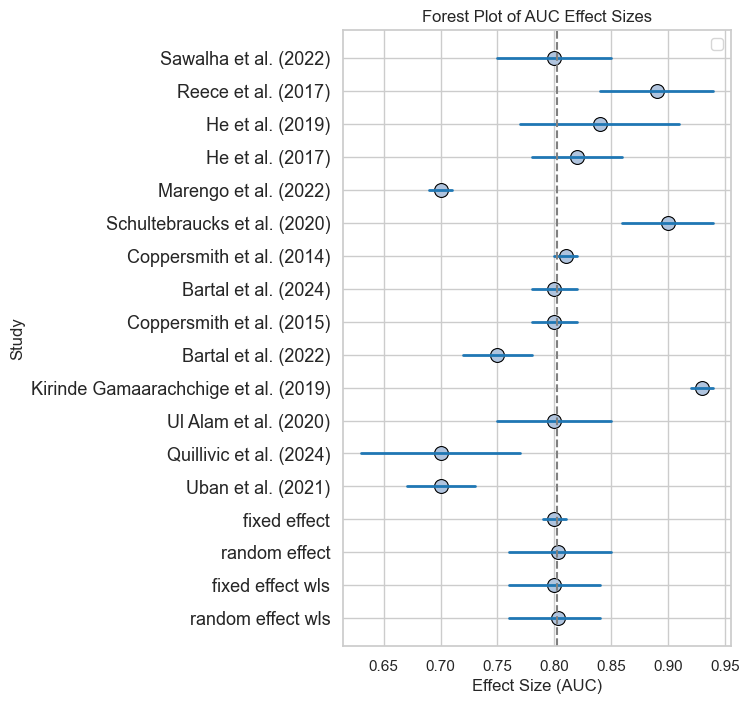

In [387]:
# Forest plot

res_df = result.summary_frame(alpha=0.05,)
res_df = res_df.rename(columns={'effect': 'eff', 'ci_low': 'ci_low', 'ci_upp': 'ci_upp'})
res_df['ci_low'] = res_df['ci_low'].round(2)
res_df['ci_upp'] = res_df['ci_upp'].round(2)

# Convert to a suitable format for plotting
res_df = res_df.reset_index()
res_df = res_df[['index', 'eff', 'ci_low', 'ci_upp']]
res_df.columns = ['Study', 'Effect', 'CI Low', 'CI High']

# Plot using Seaborn
plt.figure(figsize=(5, 8))
for i, row in res_df.iterrows():
    plt.plot([row['CI Low'], row['CI High']], [i, i], color=custom_blue, lw=2)

#res_df  = res_df.merge(cleaned_data[['authors_cleaned','data_source_cat']], left_on='Study', right_on='authors_cleaned')
# Plot point estimates and confidence intervals
sns.scatterplot(data=res_df, x='Effect', y='Study', color="lightsteelblue",  s=100, edgecolor='black',)# hue='data_source_cat')

# Plot error bars (confidence intervals)


plt.axvline(x=pooled_effect.mean(), color='gray', linestyle='--')
plt.xlabel('Effect Size (AUC)')
plt.yticks(fontsize=13)
plt.ylabel('Study')
plt.title('Forest Plot of AUC Effect Sizes')
plt.legend()
plt.show()

### Statistical Tests

In [376]:
## statistical test

# Sensitivity Analysis: Leave-One-Out
def leave_one_out_analysis(cleaned_data):
    results = []
    
    for i in range(len(cleaned_data)):
        leave_one_out_data = cleaned_data.drop(cleaned_data.index[i])
        effects = leave_one_out_data['AUC'].values
        variances = leave_one_out_data['variance'].values
        result = combine_effects(effects, variances, method_re='dl')
        ci_low, ci_high = result.conf_int_samples()
        ci_low, ci_high = ci_low[0], ci_high[0]  # Convert arrays to scalars
        results.append((result.effect, ci_low, ci_high))
    
    return results



# Publication Bias: Egger's Test
def egger_test(cleaned_data):
    auc_values = cleaned_data['AUC'].values
    std_errors = cleaned_data['std_error'].values
    
    # Perform regression of standardized effect size on precision
    precision = 1 / std_errors
    standardized_effect = auc_values / std_errors
    model = sm.OLS(standardized_effect, sm.add_constant(precision)).fit()
    p_value = model.pvalues[1]
    
    return p_value



sensitivity_results = leave_one_out_analysis(cleaned_data)
p_value_egger = egger_test(cleaned_data)
print(f"Egger's test p-value: {p_value_egger}")

# Homogeneity Test
homogeneity_test = result.test_homogeneity()
print(f"Homogeneity test p-value: {homogeneity_test[1]}")

# Print Pooled AUC Result
pooled_effect = result.effect.mean()
pooled_var = result.variance
ci_low, ci_high = result.conf_int_samples()
ci_low, ci_high = ci_low[0], ci_high[0]

print(f"Pooled AUC: {pooled_effect:.2f} (95% CI: {ci_low:.2f}, {ci_high:.2f})")

Egger's test p-value: 6.212879057691777e-11
Homogeneity test p-value: 1.5498592844347805e-131
Pooled AUC: 0.80 (95% CI: 0.75, 0.85)


In [375]:

def compute_stats(cleaned_data, result):
    sensitivity_results = leave_one_out_analysis(cleaned_data)
    p_value_egger = egger_test(cleaned_data)
    print(f"Egger's test p-value: {p_value_egger}")

    # Homogeneity Test
    homogeneity_test = result.test_homogeneity()
    print(f"Homogeneity test p-value: {homogeneity_test[1]}")

    # Print Pooled AUC Result
    pooled_effect = result.effect.mean()
    pooled_var = result.variance
    ci_low, ci_high = result.conf_int_samples()
    ci_low, ci_high = ci_low[0], ci_high[0]

    print(f"Pooled AUC: {pooled_effect:.2f} (95% CI: {ci_low:.2f}, {ci_high:.2f})")

cleaned_data_2 = cleaned_data[cleaned_data.data_source_cat != "Social Media post"]


# Calculate pooled effect size using random effects model
effects = cleaned_data_2['AUC'].values
variances = cleaned_data_2['variance'].values

result_2 = combine_effects(effects, variances, method_re='dl', row_names=cleaned_data_2['authors_cleaned'].values)

compute_stats(cleaned_data_2, result_2)


Egger's test p-value: 9.702812824766766e-07
Homogeneity test p-value: 1.421932140674269e-30
Pooled AUC: 0.79 (95% CI: 0.75, 0.85)


In [397]:
N_bis = cleaned_data_2.sample_size_clean.sum()
print(f"Total number of participants when excluding social media data: {N_bis}")


Total number of participants when excluding social media data: 8381


In [302]:
result.summary_frame()

,eff,sd_eff,ci_low,ci_upp,w_fe,w_re
Sawalha et al. (2022),0.800000,0.024121,0.752724,0.847276,0.013525,0.069774
Reece et al. (2017),0.890000,0.023652,0.843642,0.936358,0.014066,0.070001
He et al. (2019),0.840000,0.036845,0.767785,0.912215,0.005796,0.062701
He et al. (2017),0.820000,0.022181,0.776526,0.863474,0.015994,0.070697
Marengo et al. (2022),0.700000,0.006450,0.687359,0.712641,0.189151,0.075722
Schultebraucks et al. (2020),0.900000,0.020180,0.860448,0.939552,0.019322,0.071591
Coppersmith et al. (2014),0.810000,0.004700,0.800788,0.819212,0.356167,0.075955
Bartal et al. (2024),0.800000,0.011115,0.778214,0.821786,0.063688,0.074755
Coppersmith et al. (2015),0.800000,0.009573,0.781238,0.818762,0.085868,0.075128
Bartal et al. (2022),0.750000,0.013727,0.723095,0.776905,0.041757,0.074007


###  Figure 12. Funnel plot of the study providing classification performances (AUC or equivalent)

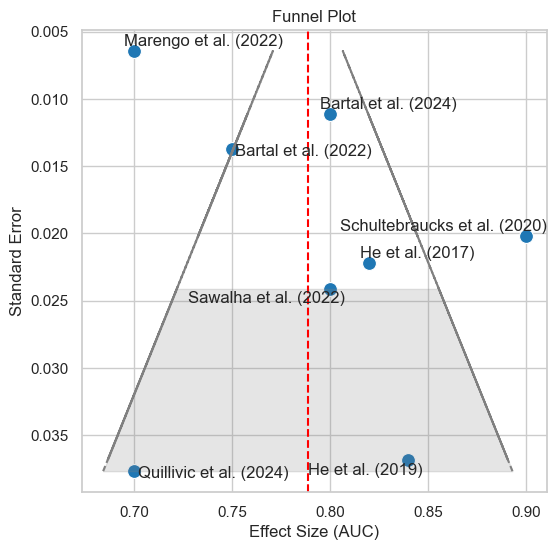

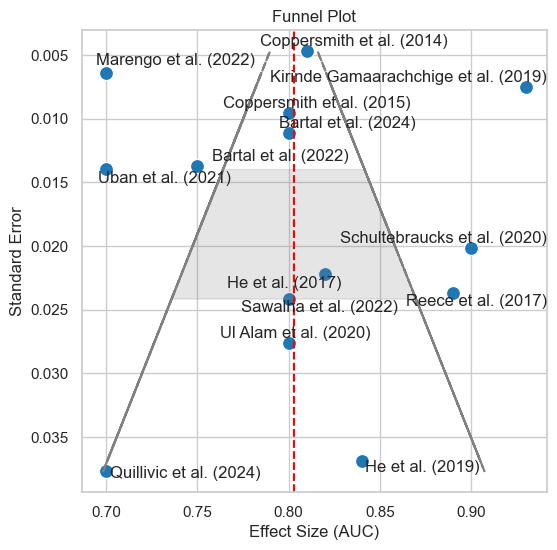

In [399]:
from adjustText import adjust_text

def funnel_plot(result, clean_data):
    res_df = result.summary_frame()
    res_df = res_df[~res_df.index.str.contains('effect')]
    res_df['Study'] = res_df.index
    res_df  = res_df.merge(cleaned_data[['authors_cleaned','data_source_cat']], left_on='Study', right_on='authors_cleaned')
    res_df['std_error'] = res_df['sd_eff']

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=res_df['eff'], y=res_df['std_error'], color=custom_blue, s=100,)# hue=res_df['data_source_cat'])
    
    # Plot pseudo 95% confidence intervals
    z = np.sqrt(2) * 1.96  # for 95% CI
    pseudo_ci_low = result.effect.mean() - z * res_df['std_error']
    pseudo_ci_high = result.effect.mean() + z * res_df['std_error']
    
    plt.plot(pseudo_ci_low, res_df['std_error'], linestyle='--', color='gray')
    plt.plot(pseudo_ci_high, res_df['std_error'], linestyle='--', color='gray')
    
    # Inverted funnel
    plt.fill_betweenx(res_df['std_error'], pseudo_ci_low, pseudo_ci_high, color='gray', alpha=0.2)

    plt.axvline(result.effect.mean(), color='red', linestyle='--')
    plt.xlabel('Effect Size (AUC)')
    plt.ylabel('Standard Error')
    plt.title('Funnel Plot')
    plt.gca().invert_yaxis()


    texts = []
    for i, row in res_df.iterrows():
        texts.append(plt.text(row['eff'], row['std_error'], res_df.Study[i],
                              fontsize=12, ha='center', va='center'))
    adjust_text(texts)

    plt.show()
    plt.show()

funnel_plot(result_2, cleaned_data_2)
funnel_plot(result, cleaned_data)

## Figure S3 Funnel plot with data source as HUE

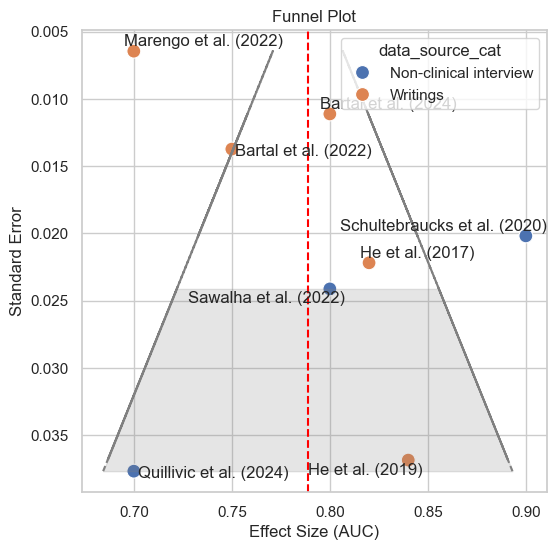

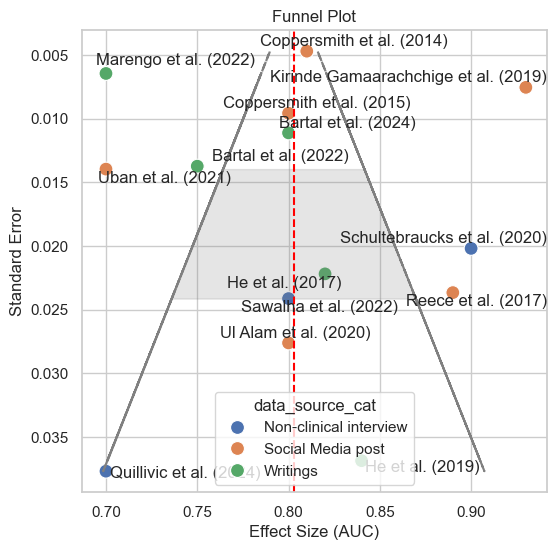

In [398]:
from adjustText import adjust_text

def funnel_plot(result, clean_data):
    res_df = result.summary_frame()
    res_df = res_df[~res_df.index.str.contains('effect')]
    res_df['Study'] = res_df.index
    res_df  = res_df.merge(cleaned_data[['authors_cleaned','data_source_cat']], left_on='Study', right_on='authors_cleaned')
    res_df['std_error'] = res_df['sd_eff']

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=res_df['eff'], y=res_df['std_error'], color=custom_blue, s=100, hue=res_df['data_source_cat'])
    
    # Plot pseudo 95% confidence intervals
    z = np.sqrt(2) * 1.96  # for 95% CI
    pseudo_ci_low = result.effect.mean() - z * res_df['std_error']
    pseudo_ci_high = result.effect.mean() + z * res_df['std_error']
    
    plt.plot(pseudo_ci_low, res_df['std_error'], linestyle='--', color='gray')
    plt.plot(pseudo_ci_high, res_df['std_error'], linestyle='--', color='gray')
    
    # Inverted funnel
    plt.fill_betweenx(res_df['std_error'], pseudo_ci_low, pseudo_ci_high, color='gray', alpha=0.2)

    plt.axvline(result.effect.mean(), color='red', linestyle='--')
    plt.xlabel('Effect Size (AUC)')
    plt.ylabel('Standard Error')
    plt.title('Funnel Plot')
    plt.gca().invert_yaxis()


    texts = []
    for i, row in res_df.iterrows():
        texts.append(plt.text(row['eff'], row['std_error'], res_df.Study[i],
                              fontsize=12, ha='center', va='center'))
    adjust_text(texts)

    plt.show()
    plt.show()

funnel_plot(result_2, cleaned_data_2)
funnel_plot(result, cleaned_data)

## Figure 13. Galbraith Plot of Standardized Effect Sizes vs. Precision for Studies including performance metrics.

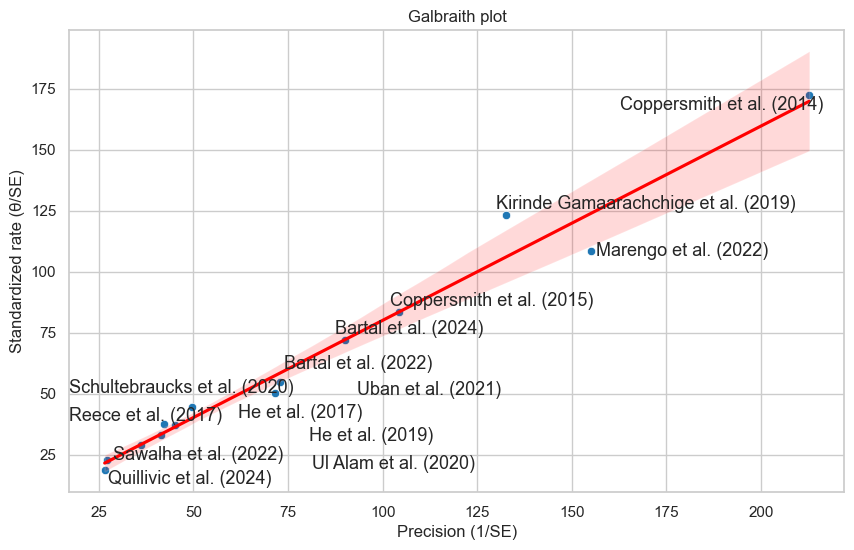

In [374]:
# Galbraith plot function
def galbraith_plot(result,):
    res_df = result.summary_frame()
    res_df['std_error'] = res_df['sd_eff']  # Use 'sd_eff' for standard error

    # Filter out the summary rows
    res_df = res_df[~res_df.index.str.contains('effect')]

    res_df['standardized_rate'] = res_df['eff'] / res_df['std_error']
    res_df['precision'] = 1 / res_df['std_error']

    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(x=res_df['precision'], y=res_df['standardized_rate'], color=custom_blue)

    # Add regression line
    sns.regplot(x='precision', y='standardized_rate', data=res_df, scatter=False, color='red', ax=ax)

    #plt.fill_between(res_df['precision'], res_df['standardized_rate'] - 1.96, res_df['standardized_rate'] + 1.96, color='gray', alpha=0.2)

    plt.xlabel('Precision (1/SE)')
    plt.ylabel('Standardized rate (θ/SE)')
    plt.title('Galbraith plot')

    # Add annotations
    texts = []
    for i, row in res_df.iterrows():
        texts.append(plt.text(row['precision'], row['standardized_rate'], i,
                              fontsize=13, ha='center', va='center'))
    adjust_text(texts)

    plt.show()

galbraith_plot(result,)

In [350]:
 
def count_points_on_sides(res_df, pooled_effect):
    left_count = len(res_df[res_df['eff'] < pooled_effect])
    right_count = len(res_df[res_df['eff'] > pooled_effect])
    return left_count, right_count

# Generate summary frame
res_df = result.summary_frame()
res_df = res_df[~res_df.index.str.contains('effect')]
res_df['std_error'] = res_df['sd_eff']  # Use 'sd_eff' for standard error

# Count points on each side of the pooled effect size
pooled_effect = result.effect.mean()
left_count, right_count = count_points_on_sides(res_df, pooled_effect)

print(f"Number of points on the left side of the pooled effect size: {left_count}")
print(f"Number of points on the right side of the pooled effect size: {right_count}")

Number of points on the left side of the pooled effect size: 8
Number of points on the right side of the pooled effect size: 6


In [120]:
## Analysis

row_data['statistical_framework_clean'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')

statistical_framework_clean
Descriptive statistics                                                           37.93%
Descriptive statistics, Inferential statistics                                   25.86%
Supervised Machine Learning                                                      13.79%
Descriptive statistics, Supervised Machine Learning                               5.17%
Supervised Deep Learning                                                          5.17%
Supervised Machine Learning, Supervised Deep Learning                             3.45%
                                                                                  3.45%
Descriptive statistics, Inferential statistics, Supervised Machine Learning       1.72%
Inferential statistics                                                            1.72%
Descriptive statistics, Supervised Machine Learning, Supervised Deep Learning     1.72%
Name: proportion, dtype: object